
<h1><center>Computer Vision with Deep Learning</center></h1>
<h3><center>Course Project @ FHNW</center></h3>
<p><center><i>29.01.2022</i></center></p>
<p><center><i>Claudio Schmidli</i></center></p>


<p align="center"><em>Abstract</em></p>

<p align="center"><em>This project investigates the application of deep learning models for the classification of particle images obtained through Micro-Flow Imaging (MFI). The study explores various pre-trained models, transfer learning, and fine-tuning techniques to address the challenge of classifying imbalanced datasets, containing images of particles in pharmaceutical formulations. The results indicate that fine-tuned pre-trained models, especially ensembles, perform best in terms of accuracy and F1 score. The project demonstrates that deep learning techniques can extract more meaningful insights from MFI data compared to traditional thresholding methods. Depending on the deployment location, models such as MobileNet are recommended for edge devices, while the ensemble model is more suitable for environments where performance is less critical. The findings contribute to advancing the understanding of particle characteristics in drug manufacturing, providing a solid foundation for further research and application.</em></p>

<p align="center"><em>Summary Table of Model Performance</em></p>

| Rank | Model Name                     | Type                              | Trainable Parameters | Accuracy Val | Accuracy Test | F1 Val | F1 Test |
|------|---------------------------------|-----------------------------------|----------------------|--------------|---------------|--------|---------|
| 1    | Model Ensemble                 | ResNet50 + MobileNet              | 24M                  | n/a          | 0.9401        | n/a    | 0.9284  |
| 2    | InceptionV3                    | Fine-tuning                       | 22M                  | 0.9600       | 0.9288        | 0.9288 | 0.9180  |
| 3    | RESNET50_FINE_TUNE             | Fine-tuning                       | 24M                  | 0.9400       | 0.9316        | 0.9298 | 0.9169  |
| 4    | Transfer_Learning_MobileNet    | Transfer Learning                 | 20K                  | 0.9114       | 0.9116        | 0.8994 | 0.9031  |
| 5    | ResNet34                        | Self-constructed ResNet34         | 26M*                 | 0.8942       | 0.9002        | 0.8716 | 0.8895  |
| 6    | RESNET50_FROM_ZERO             | Train from Scratch                | 24M                  | 0.8886       | 0.8945        | 0.8705 | 0.8832  |
| 7    | Simple_FC_Network              | Simple FC Network from Scratch    | 151K                 | 0.5285       | 0.3455        | 0.5351 | 0.3650  |



# Introduction
Micro-flow imaging (MFI) is a technique used in the drug manufacturing industry to study subvisible particles in pharmaceutical formulations. This information is crucial for the development and quality control of pharmaceutical products. In most studies, particle concentrations in different size ranges are reported. The data obtained by MFI is collected using a digital camera. The sample is passed through a flow cell, where the camera captures particle images in high resolution. Compared to other methods, this also provides visual information. However, the image data is not used to its full extent. Existing data processing methods are based on thresholding, which is the simplest method of image segmentation. The binary image transformation generated in this way lacks information for more sophisticated data analysis. **Figure 1** shows the sparse data provided by the manufacturer's software.


In this notebook, I show an alternative image analysis approach based on neuronal networks. Six different models were developed to classify pixel images. I demonstrate that neuronal networks can provide valuable information about the different particle types in pharmaceutical formulations.


**Figure 1:** *Right: MFI image frame containing one single particle (could be more than one). Left: Particle characteristics provided by the MFI software. The numbers are based on image thresholding.*
![Figure 1](./static/Introduction/image_frame_with_particle.jpg)

# Methodology
### Creation of dataset
In order to train CNN models, a dataset had to be created first. Therefore, three different biolocigal samples consisting of antibodies and saliva were measured. In this way, several thousands of image frames were collected. Following that, the raw data, which included images and CSV files, was processed in Python with the notebook <a href="data_collection and_analysis/MFI_Analysis_Main.ipynb">data_collection and_analysis/MFI_Analysis_Main.ipynb</a>. The script depends on a config.ini file and input parameters defined in Excel. During the execution a logs are written in a .log file. The script reads the raw data, calculates different particle concentrations, and crops every particle using the thresholding approach mentioned above. In this way, a dataset of 2338  was created. The generated particle images were then manually labeled into five classes as follows: 
- 826 Bubbles 
- 202 Cells
- 380 Dark 
- 281 Fiber
- 650 Protein

As you can see, this is an imbalanced dataset. E.g., bubbles are more represented than cells. To deal with this, all models were trained by applying class weights.

### Load and preprocess dataset
To load and preprocess the dataset a class named **Data** was written. The class is build on <a href="https://www.tensorflow.org/api_docs/python/tf/data">tf.data</a> for a finer control. 

The class provides the following functionality:
- Read image data
- Read image labels from image path
- Calculate the class weight for each class
- Perform train/val/test split based on given parameters (70% train, 15% val and 15% test was used later on)
- Image resizing by scaling, cropping or zero padding with black values (zero-padding has no effect on the classification accuracy but considerably reduces the training time, see <a href="https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0263-7">this paper</a>)
- Rescale image to values between 0 and 1 
- Image caching
- Image batching
- Image augmentation (flip images) This was only performed on the training data!
- Prefetching

The dataset can be inspected as follows:

# Initialize notebook

In [1]:
from sklearn.metrics import get_scorer
from sklearn.metrics import f1_score
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/PC_Vision/Project/'
#@Amadeus:There is a local copy of the module folder!
from modules.dataprocessing import Data
from modules.dataprocessing import get_preprocessed_data
from modules.dataprocessing import save_model
from modules.dataprocessing import load_models
from modules.dataprocessing import WeightedAverageLayer
from modules.dataprocessing import predict_ensemble
from modules.plotmodels import PlotLearning
from modules.plotmodels import training_plot
from modules.plotmodels import GradVisualizer
from modules.plotmodels import Integrated_Gradients
from modules.initializenotebook import check_GPU_availability
from modules.initializenotebook import check_RAM_availability
from modules.initializenotebook import check_hardware
from modules.createmodels import Transfer_Learning_MobileNet
from modules.createmodels import RESNET50_FINE_TUNE
from modules.createmodels import RESNET50_FROM_ZERO
from modules.createmodels import ResNet34_Self_Made
from modules.createmodels import INCEPTIONV3_FINE_TUNE
from modules.createmodels import Simple_FC_Network
strategy = check_hardware()
data_dir='data/dataset2023.13.01'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/PC_Vision/Project
Found GPU at: /device:GPU:0
Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


Number of images in train, val and test set:
Total nbr of images:	 2338
Train set nbr of images: 1637
Val set nbr of images: 	 350
Test set nbr of images:	 351


Class weights for training:
Cell:      2.4074
Fiber:     1.5018
Protein:   0.7324
Bubble:    0.5764
Dark:      1.2216


Number of images per class in train-set
Cell:      136
Fiber:     218
Protein:   447
Bubble:    568
Dark:      268




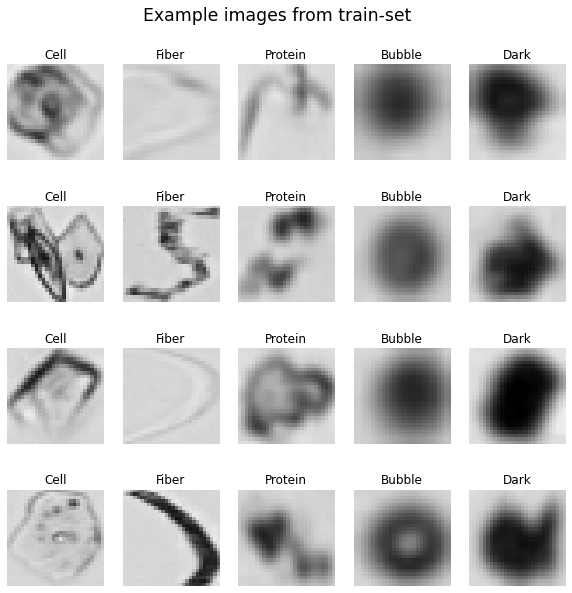

In [ ]:
data = get_preprocessed_data(
    data_dir ='data/dataset2023.13.01', 
    img_height=28, 
    img_width=28, channels=3, 
    resize_option='scale', 
    batch_size=32, 
    data_within_0_1=False,
    test_size_relative=0.15, 
    val_size_relative=0.15,
    scale_to_0_1=True,
    verbose=0,
    augment_train=True
    )

data.plot_example_images(dataset='train', seed=0, examples_per_class = 4)

data.show_img_counts()
data.show_class_weights()# for training
data.show_nbr_img_per_class('train')

In case zero padding is used for scaling the images, the dataset looks as follows:


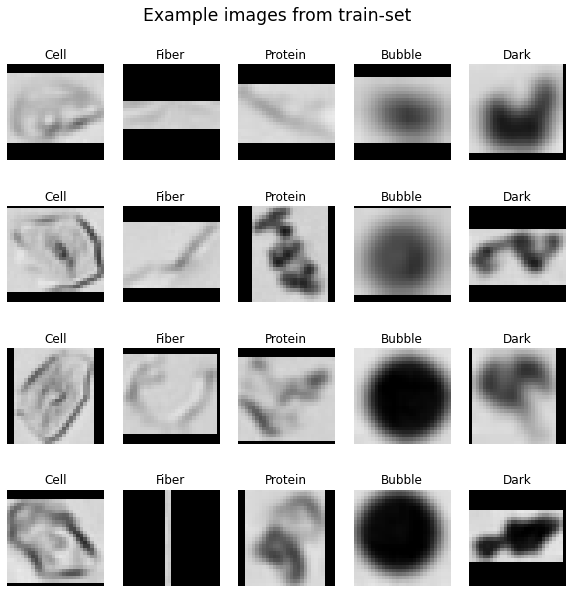

In [ ]:
data = get_preprocessed_data(
    data_dir ='data/dataset2023.13.01', 
    img_height=28, 
    img_width=28, channels=3, 
    resize_option='pad', 
    batch_size=32, 
    data_within_0_1=False,
    test_size_relative=0.20, 
    val_size_relative=0.10,
    scale_to_0_1=True,
    verbose=0,
    augment_train=True
    )

data.plot_example_images(dataset='train', seed=0, examples_per_class = 4)

### Model training

The six different models shown in **Table 1** were trained on the MFI particle dataset. The trained models include transfer learning, fine tuning, and training existing models as well as self-constructed models from scratch.

**Table 1:** *Summary of tested models.* 

|Model Name              |Type                                   |Trainable parameters
|------                      |------                                 |----                
|Model Enseble                     |ResNet50+MobileNet               |24M                 
|InceptionV3                 |Fine tuning                            |22M                 
|RESNET50_FINE_TUNE          |Fine tuning                            |24M                 
|Transfer_Learning_MobileNet |Transfer learning                      |20K                 
|ResNet34                    |Self-constructed ResNet34 architecture |26M*                
|RESNET50_FROM_ZERO          |Train from zero                        |24M                 
|Simple_FC_Network           |Simple FC network trained from scratch |151K   

For fine tuning a learning rate schedule featuring a warm-up ramp was applied (see **Figure 2** in results section). For models trained from zero a learning rate with an exponential decay was used  (see **Figure 3** in results section). 

### Model evaluation
For model evaluation the following features were added to the Data class:
- Show examples for correct and incorrect classified particles
- Show the confusion matrix for any dataset (train, test or val)
- Attribute the model's prediction to its input features using integrated gradients
- Calculate the accuracy and F1 scores for any dataset (train, test or val)

# Results

### Transfer learning


Transfer learning was performed on MobileNetV2. This type of model belongs to a family of neural network architectures for efficient on-device image classification. MobileNetV2 is very similar to the original MobileNet, except that it uses inverted residual blocks with bottlenecking features. It has a drastically lower parameter count than the original MobileNet. A pretrained instance of the network was downloaded from <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4">TensorFlowHub</a>. The layers were then specified as not trainable, ensuring that the weights were not modified. On top of the feature maps of the pretrained model, a new classifier was added (two dense layers). These additional layers were trained from scratch to repurpose the MobileNetV2 network. The model was set up as a class object, taking its hyperparameters as arguments when it was instantiated. The learning rate, l1/l2 regularization, number of nodes in the second-last hidden layer, number of epochs, and patience for "EarlyStopping" are set when you instantiate a class object. These parameters were manually tested (not shown for the sake of clarity). The results for the best parameters are shown below. Initial experiments and literature research showed that the "Adam optimizer" is the tried-and-proven choice for deep learning on this type of data set. For this reason, the opimizer is set to Adam by default. In order to handle the imbalance of the dataset, the model was trained by applying class weights.


For evaluating the model, example images of incorrectly as well as correctly predicted particles are shown. Additionally, the confusion matrix on the validation dataset, the integrated gradients for image attribution, and the accuracy and F1 (macro) metric on the validation and test sets are shown. The F1 score was chosen as an additional measure due to the imbalance of the data.

### MobileNetV2 (Transfer learning)

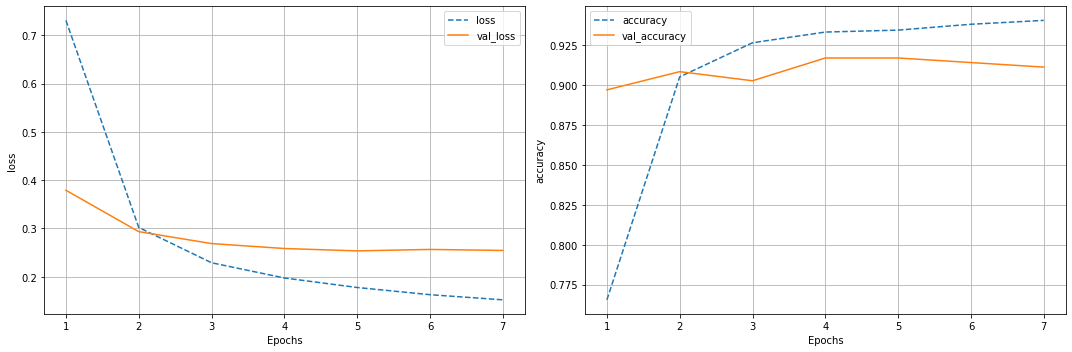


103/103 [==============================] - 3s 29ms/step - loss: 0.1522 - accuracy: 0.9407 - val_loss: 0.2544 - val_accuracy: 0.9114
Saving model ./trained_models/Transfer_Learning_MobileNet


In [16]:
data = get_preprocessed_data(
    data_dir ='data/dataset2023.13.01', 
    img_height=224, 
    img_width=224, 
    channels=3, 
    resize_option='scale', 
    batch_size=16, 
    data_within_0_1=False,
    test_size_relative=0.15, 
    val_size_relative=0.15,
    scale_to_0_1=False,
    verbose=1,
    augment_train=True
    )

model = Transfer_Learning_MobileNet(data,
                      lrate = 0.0005,
                      l1 = 0.,
                      l2 = 0.,
                      num_hidden = 16,
                      epochs = 15,
                      patience = 2)

model.train_and_evaluate()
save_model(model, './trained_models/Transfer_Learning_MobileNet')

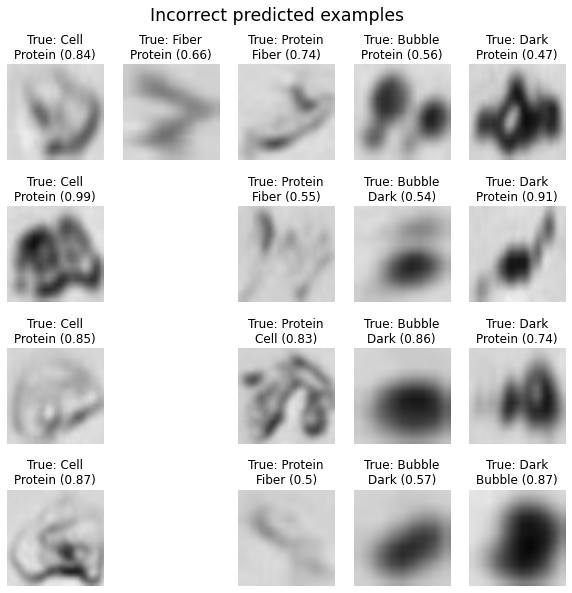

In [17]:
data.plot_prediction(model.model, dataset="val", pred_correct=False, seed=0, examples_per_class=4)

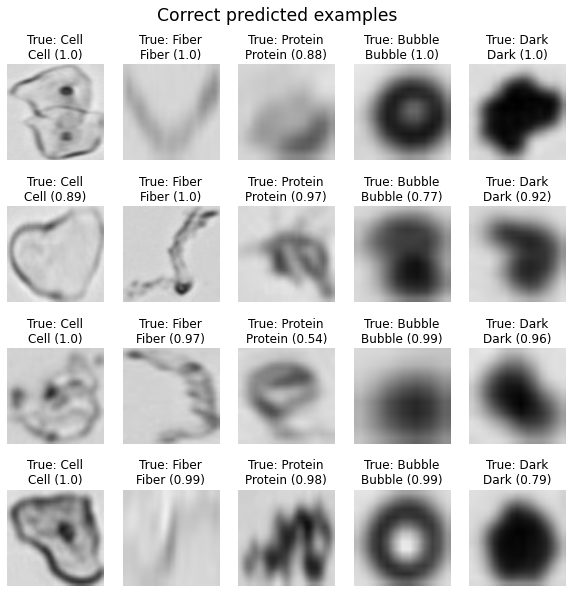

In [18]:
data.plot_prediction(model.model, dataset="val", pred_correct=True, seed=0, examples_per_class=4)

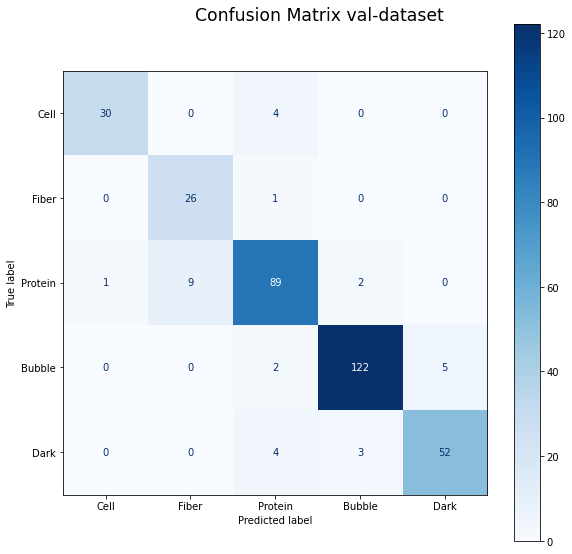

In [19]:
data.plot_confusion_matrix(dataset="val")

In [20]:
data.show_predictions(model.model, dataset='val')
data.show_predictions(model.model, dataset='test')

Accuracy socre on validation set:	 0.9114285714285715
F1 macro socre on validation set:	 0.8994070927875383
Accuracy socre on test set:		 0.9116809116809117
F1 macro socre on test set:		 0.9031939906939908


Predicted: Protein


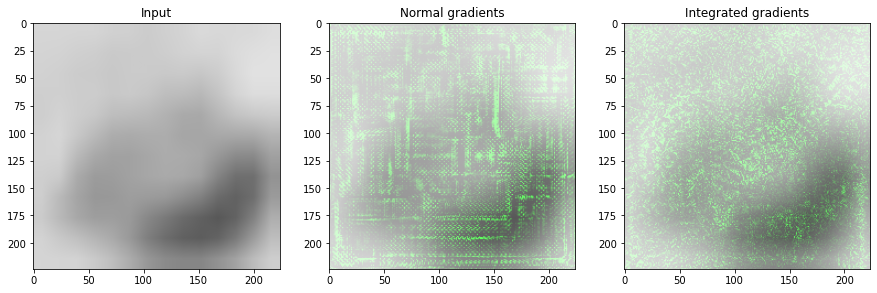

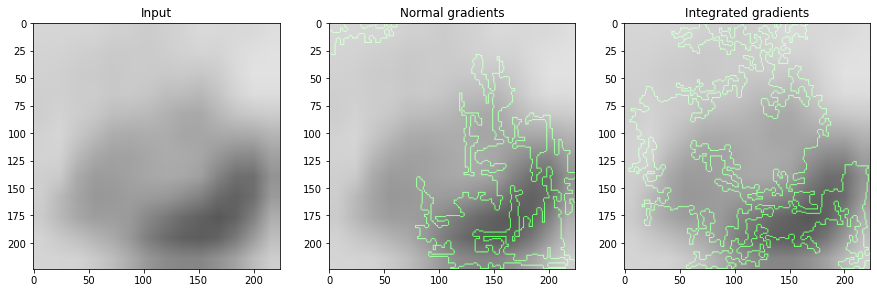

In [14]:
Integrated_Gradients(data, model, dataset='val', image_index=0)

### Fine-Tuning
In the example above, all layers that compromise MobileNet were taken and used as they are. This was achieved by setting the layers to non-trainable. Only the last two dense layers were trained on the MFI particle dataset. However, in many cases, better results are seen if the training loop can also adapt the pretrained layers. This technique is called fine-tuning. Theoretically, the only thing needed is to flip the trainable flag from "false" to "true." In practice, it is not quite so simple. When setting the learning rate to high, the pretrained weights are being changed in large steps, and all the information learned during the pretraining is lost. Setting the learning rate too low may result in very slow convergence. Finding a good reversion rate can thus be difficult. A learning rate schedule is used to address this issue (see **Figure 2**). When starting the training, the learning rate is set high. Later on, it exponentially decays during the training. Two different model architectures were trained using fine-tuning: InceptionV3 and ResNet50. Objects were created, as previously stated, for each object of a parametrizable class. Different hyperparameters were manually tested, and the best results are shown below.


**Figure 2:** *Learning rate schedule that features a warm-up ramp. This type of schedule was used for fine tuning*  
![](https://drive.google.com/uc?id=16C72EgatmpsA3mF0fhzzD4bbxeKq5Mxm)
![](https://drive.google.com/uc?id=)

### InceptionV3 (Fine-Tuning)

In [ ]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
data = get_preprocessed_data(
    data_dir ='data/dataset2023.13.01', 
    img_height=512, 
    img_width=512, 
    channels=3, 
    resize_option='scale', 
    batch_size=BATCH_SIZE, 
    data_within_0_1=False,
    test_size_relative=0.15, 
    val_size_relative=0.15,
    scale_to_0_1=False, #Pre processing is done within the model
    verbose=1,
    augment_train=True
    )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 particle_prob (Dense)       (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________
Saving model ./trained_models/INCEPTIONV3_FINE_TUNE


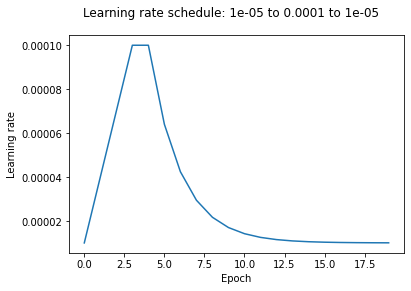

In [ ]:
model = INCEPTIONV3_FINE_TUNE(
                          data, 
                          strategy,
                          LR_START = 0.00001,
                          LR_MAX = 0.0001 * strategy.num_replicas_in_sync,
                          LR_MIN = 0.00001,
                          LR_RAMPUP_EPOCHS = 3,
                          LR_SUSTAIN_EPOCHS = 1,
                          LR_EXP_DECAY = 0.6 ,
                          EPOCHS=20, 
                          PATIENCE=5    
                          )
model.plot_learning_schedule()
model.create_model()
model.train_and_evaluate()
save_model(model, './trained_models/INCEPTIONV3_FINE_TUNE')

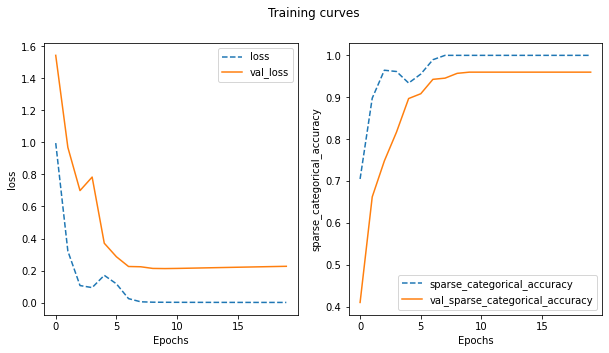

In [ ]:
training_plot(['loss', 'sparse_categorical_accuracy'], model.model.history)

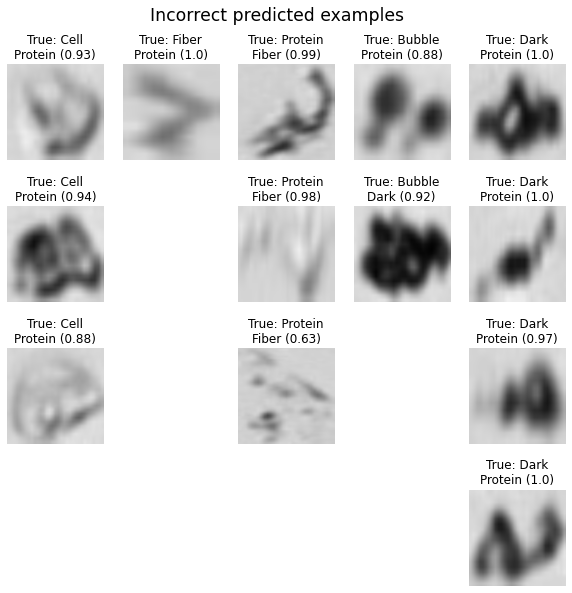

In [ ]:
data.plot_prediction(model.model, dataset="val", pred_correct=False, seed=0, examples_per_class=4)

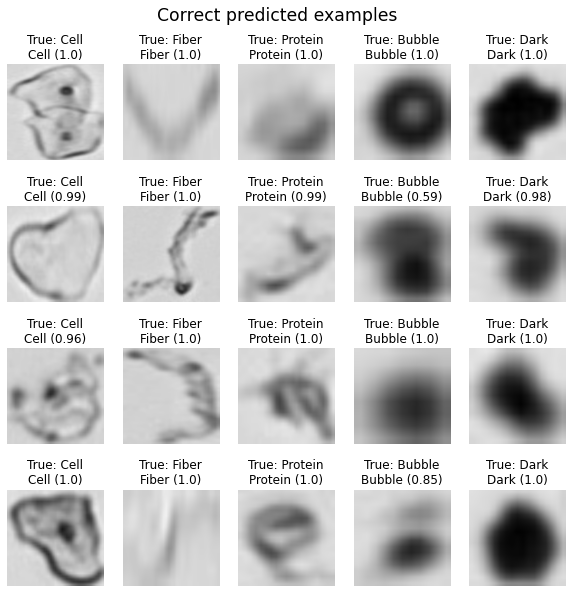

In [ ]:
data.plot_prediction(model.model, dataset="val", pred_correct=True, seed=0, examples_per_class=4)

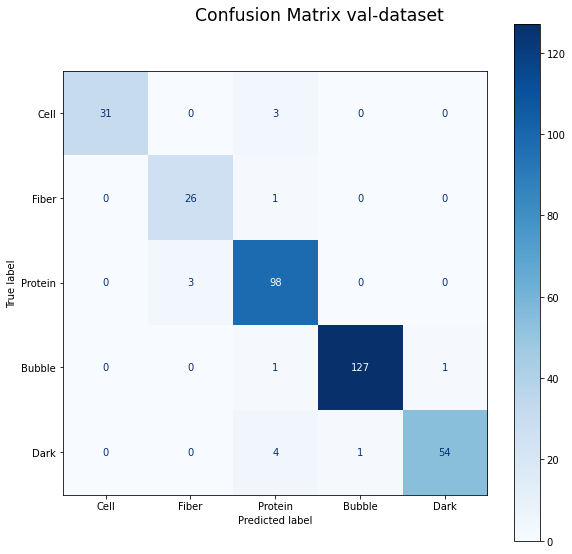

In [ ]:
data.plot_confusion_matrix(dataset="val")

In [ ]:
data.show_predictions(model.model, dataset='val')
data.show_predictions(model.model, dataset='test')

Accuracy socre on validation set:	 0.96
F1 macro socre on validation set:	 0.9520841088053867
Accuracy socre on test set:		 0.9287749287749287
F1 macro socre on test set:		 0.9180469289164941


Predicted: Protein


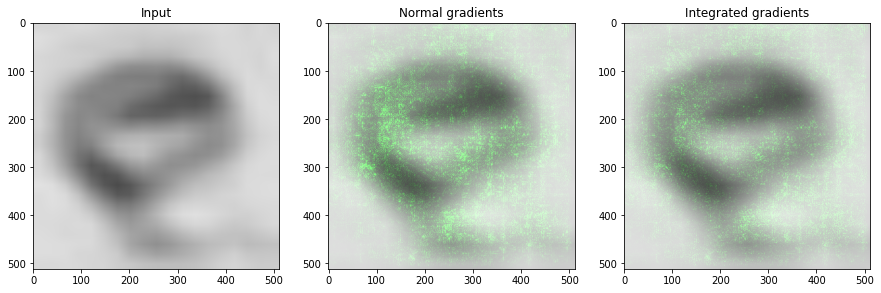

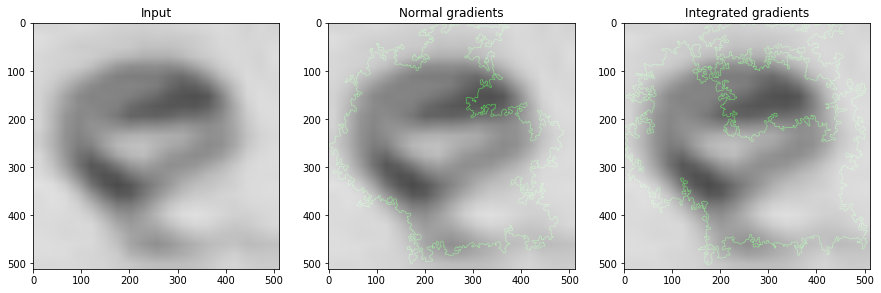

In [ ]:
Integrated_Gradients(data, model, dataset='val', image_index=10)

### ResNet50 (Fine-Tuning) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 particle_prob (Dense)       (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________
Saving model ./trained_models/RESNET50_FINE_TUNE


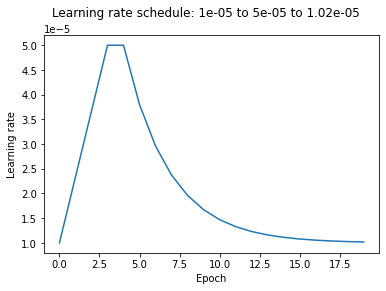

In [7]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
data = get_preprocessed_data(
    data_dir ='data/dataset2023.13.01', 
    img_height=224, #512
    img_width=224, #512
    channels=3, 
    resize_option='scale', 
    batch_size=BATCH_SIZE, 
    data_within_0_1=False,
    test_size_relative=0.15, 
    val_size_relative=0.15,
    scale_to_0_1=False, #Pre processing is done within the model
    verbose=1,
    augment_train=True
    )

model = RESNET50_FINE_TUNE(
                          data, 
                          strategy,
                          LR_START = 0.00001,
                          LR_MAX = 0.00005 * strategy.num_replicas_in_sync,
                          LR_MIN = 0.00001,
                          LR_RAMPUP_EPOCHS = 3,
                          LR_SUSTAIN_EPOCHS = 1,
                          LR_EXP_DECAY = 0.7 ,
                          EPOCHS=20, 
                          PATIENCE=5    
                          )
model.plot_learning_schedule()
model.create_model()
model.train_and_evaluate()
save_model(model, './trained_models/RESNET50_FINE_TUNE')

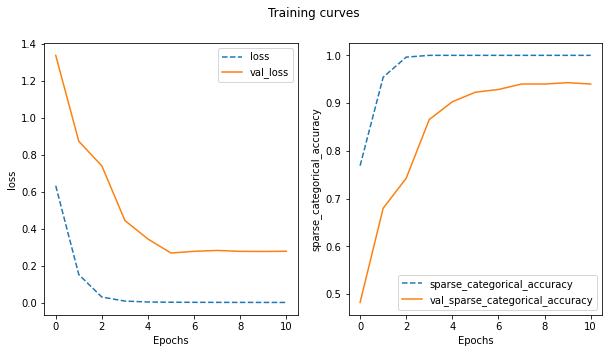

In [8]:
training_plot(['loss', 'sparse_categorical_accuracy'], model.model.history)

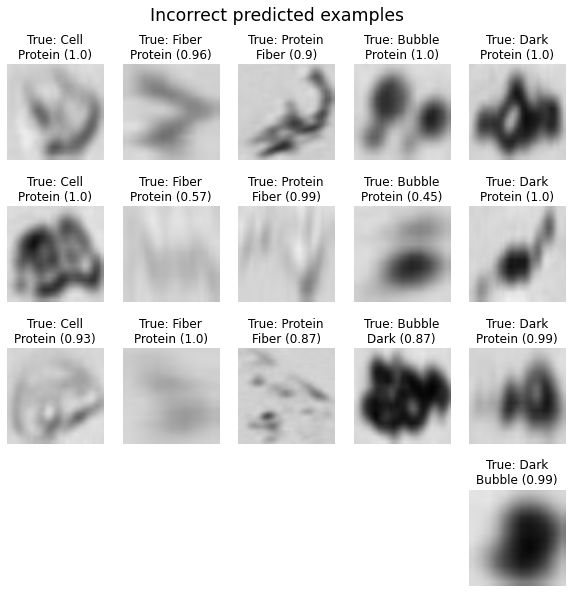

In [9]:
data.plot_prediction(model.model, dataset="val", pred_correct=False, seed=0, examples_per_class=4)

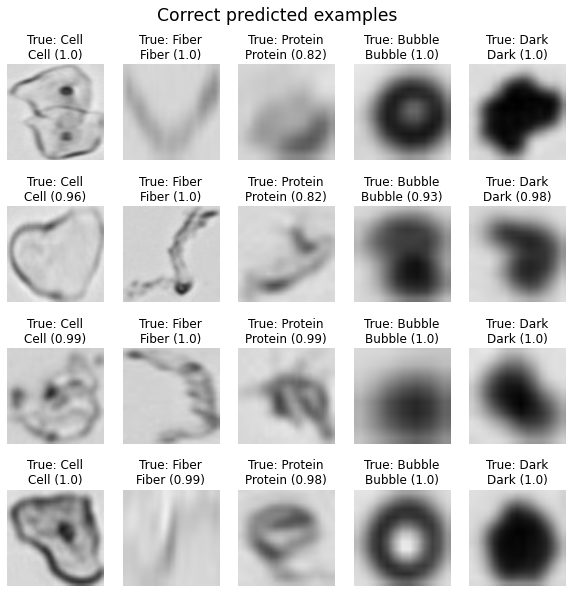

In [10]:
data.plot_prediction(model.model, dataset="val", pred_correct=True, seed=0, examples_per_class=4)

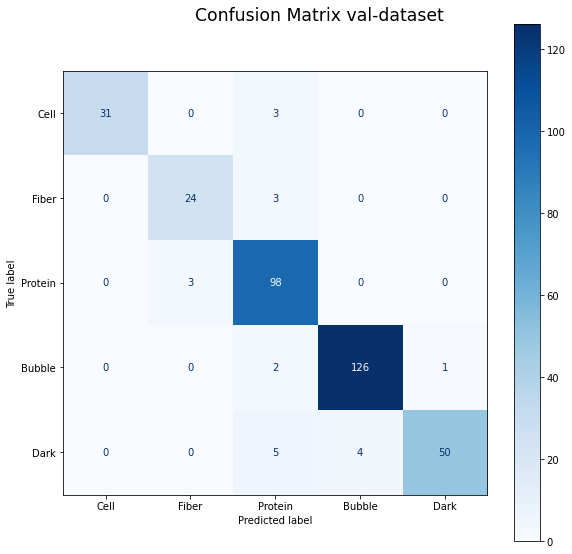

In [11]:
data.plot_confusion_matrix(dataset="val")

In [12]:
data.show_predictions(model.model, dataset='val')
data.show_predictions(model.model, dataset='test')

Accuracy socre on validation set:	 0.94
F1 macro socre on validation set:	 0.9298654453371433
Accuracy socre on test set:		 0.9316239316239316
F1 macro socre on test set:		 0.9169566810879457


Predicted: Protein


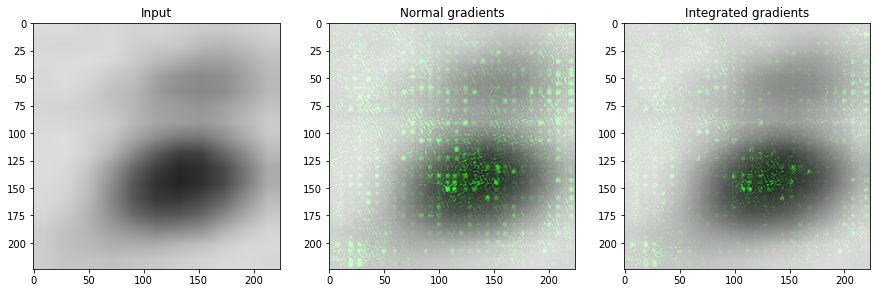

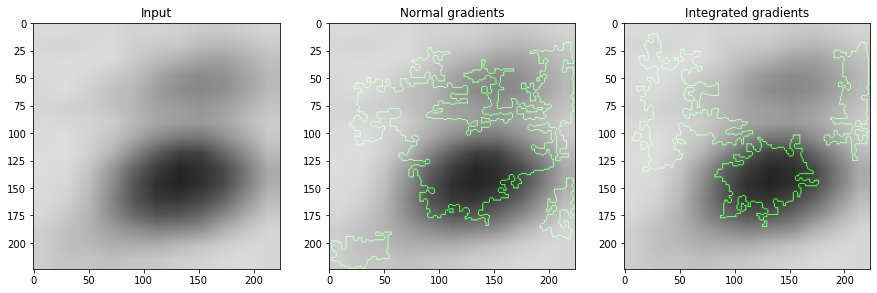

In [13]:
Integrated_Gradients(data, model, dataset='val', image_index=7)

### Training models from scratch
So far, existing model architectures initialized with weights taken from pretrained networks have been used. In this section, I investigate how these results compare models trained completely from zero. The experiment is performed on the ResNet50 architecture provided by <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications">tf.keras.applications</a> and on a ResNet34 architecture that I built from scratch using Keras layers. Similar to the fine-tuning examples, I use a learning rate schedule. However, the warming-up ramp, which is more appropriate for fine-tuning, was omitted. An example of exponentially decaying learning rate schedule can be seen in **Figure 3**.


**Figure 3:** *Traditional learning rate schedule with exponential decay. This type of schedule was used for all models that were trained from scratch.*  
![](https://drive.google.com/uc?id=15qXDgnyRrApuTTMgx1M9mqMkDlRgrvk4)
![](https://drive.google.com/uc?id=)

### ResNet50 (taken fromtf.keras.applications and trained from zero)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 particle_prob (Dense)       (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________
Saving model ./trained_models/RESNET50_FROM_ZERO


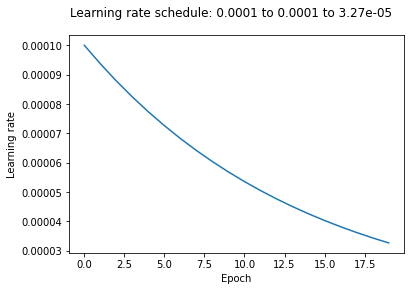

In [25]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
data = get_preprocessed_data(
    data_dir ='data/dataset2023.13.01', 
    img_height=224, #512
    img_width=224, #512
    channels=3, 
    resize_option='scale', 
    batch_size=BATCH_SIZE, 
    data_within_0_1=False,
    test_size_relative=0.15, 
    val_size_relative=0.15,
    scale_to_0_1=False, #Pre processing is done within the model
    verbose=1,
    augment_train=True
    )

model = RESNET50_FROM_ZERO(
                          data, 
                          strategy,
                          LR_START = 0.00001,
                          LR_MAX = 0.0001 * strategy.num_replicas_in_sync,
                          LR_MIN = 0.00001,
                          LR_RAMPUP_EPOCHS = 0,
                          LR_SUSTAIN_EPOCHS = 0,
                          LR_EXP_DECAY = .93 ,
                          EPOCHS=20, 
                          PATIENCE=5    
                          )
model.plot_learning_schedule()
model.create_model()
model.train_and_evaluate()
save_model(model, './trained_models/RESNET50_FROM_ZERO')

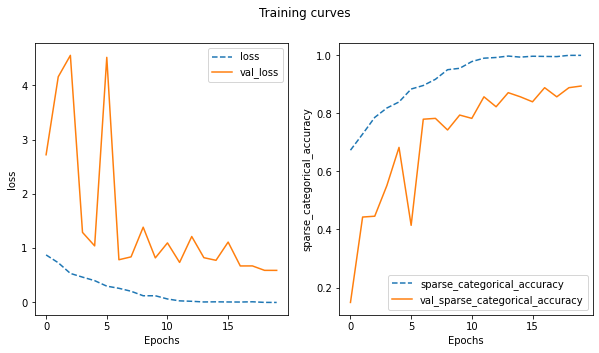

In [26]:
training_plot(['loss', 'sparse_categorical_accuracy'], model.model.history)

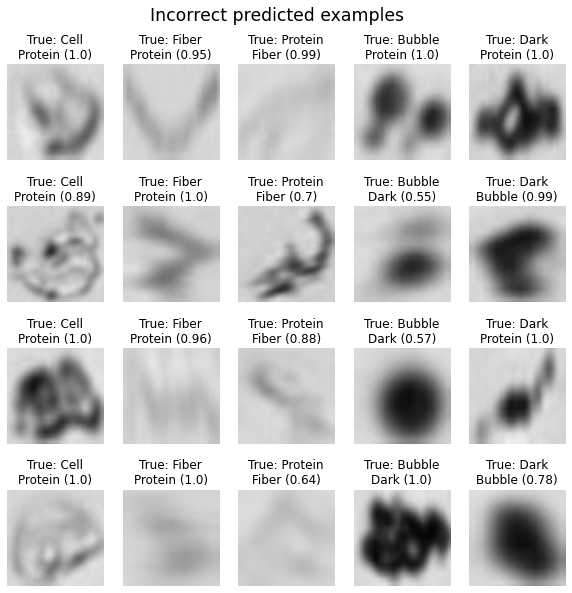

In [27]:
data.plot_prediction(model.model, dataset="val", pred_correct=False, seed=0, examples_per_class=4)

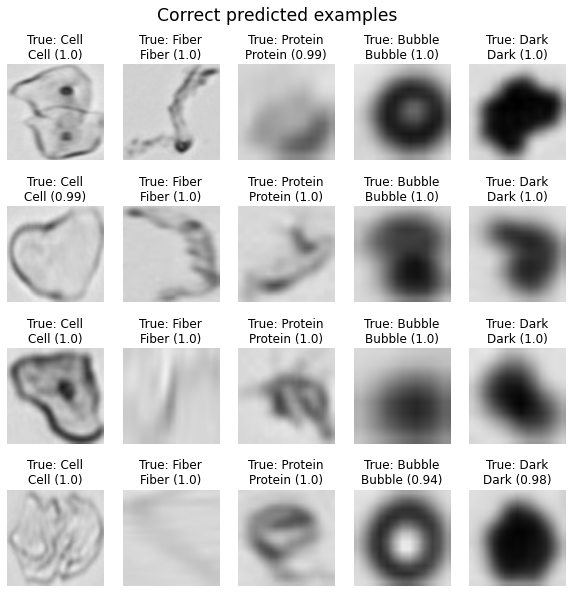

In [28]:
data.plot_prediction(model.model, dataset="val", pred_correct=True, seed=0, examples_per_class=4)

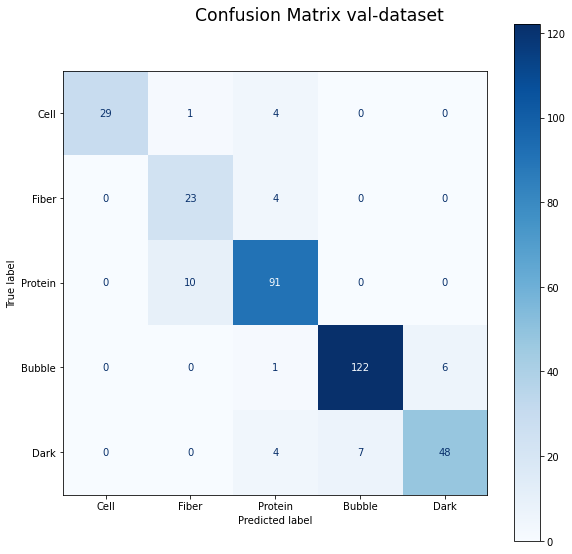

In [29]:
data.plot_confusion_matrix(dataset="val")

In [30]:
data.show_predictions(model.model, dataset='val')
data.show_predictions(model.model, dataset='test')

Accuracy socre on validation set:	 0.8942857142857142
F1 macro socre on validation set:	 0.8715664231143719
Accuracy socre on test set:		 0.9002849002849003
F1 macro socre on test set:		 0.8894798072643784


Predicted: Protein


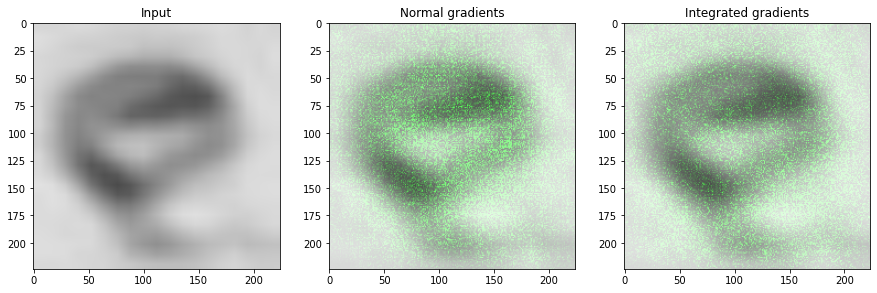

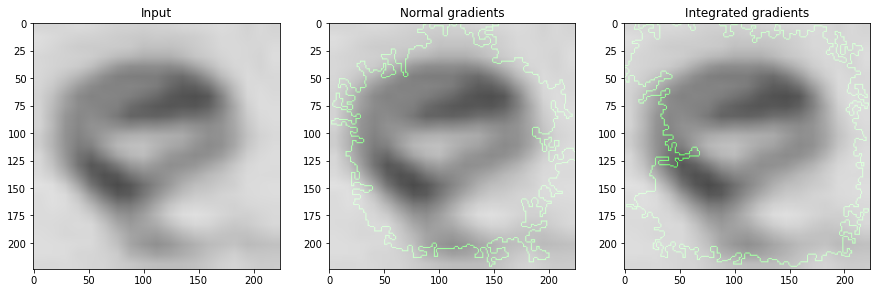

In [31]:
Integrated_Gradients(data, model, dataset='val', image_index=10)

### ResNet34 (self-constructed and trained from zero)

In [2]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
data = get_preprocessed_data(
    data_dir ='data/dataset2023.13.01', 
    img_height=224, 
    img_width=224, 
    channels=3, 
    resize_option='scale', 
    batch_size=BATCH_SIZE, 
    data_within_0_1=False,
    test_size_relative=0.15, 
    val_size_relative=0.15,
    scale_to_0_1=False, #Pre processing is done within the model
    verbose=1,
    augment_train=True
    )

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 115, 115, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

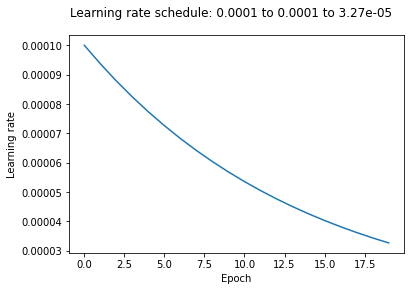

In [3]:
model = ResNet34_Self_Made(
                          data, 
                          strategy,
                          LR_START = 0.00001,
                          LR_MAX = 0.0001 * strategy.num_replicas_in_sync,
                          LR_MIN = 0.00001,
                          LR_RAMPUP_EPOCHS = 0,
                          LR_SUSTAIN_EPOCHS = 0,
                          LR_EXP_DECAY = .93 ,
                          EPOCHS=20, 
                          PATIENCE=5    
                          )
model.plot_learning_schedule()
model.create_model()
model.train_and_evaluate()
save_model(model, './trained_models/ResNet34_Self_Made')

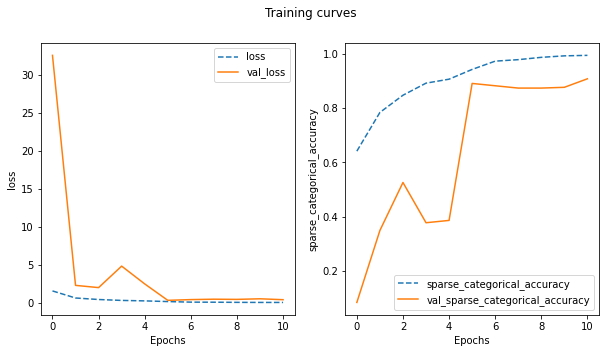

In [4]:
training_plot(['loss', 'sparse_categorical_accuracy'], model.model.history)

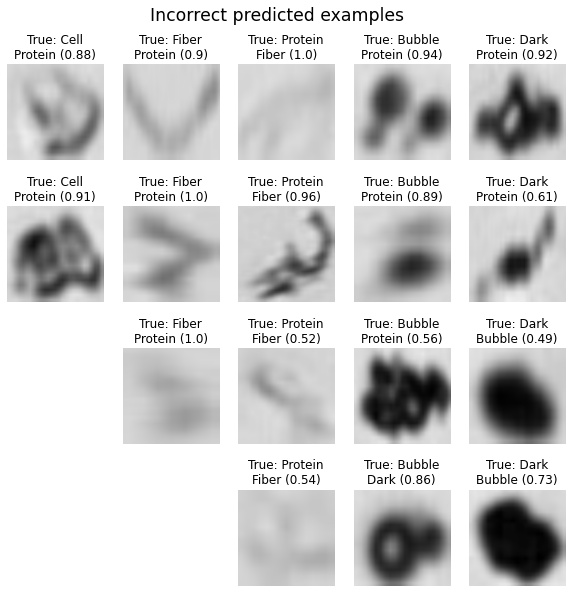

In [5]:
data.plot_prediction(model.model, dataset="val", pred_correct=False, seed=0, examples_per_class=4)

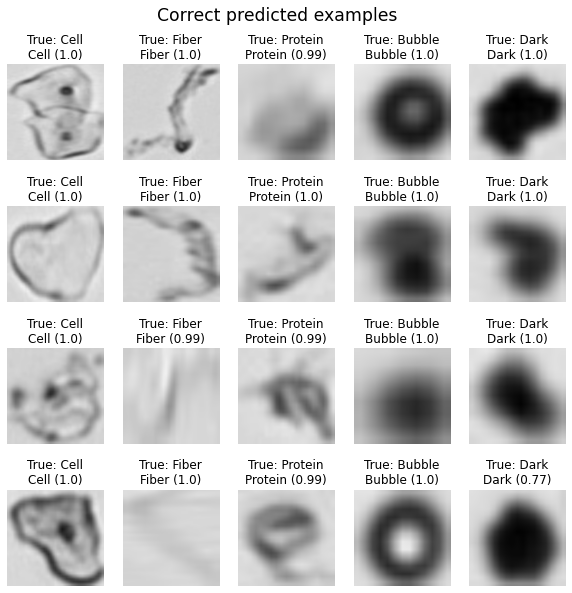

In [6]:
data.plot_prediction(model.model, dataset="val", pred_correct=True, seed=0, examples_per_class=4)

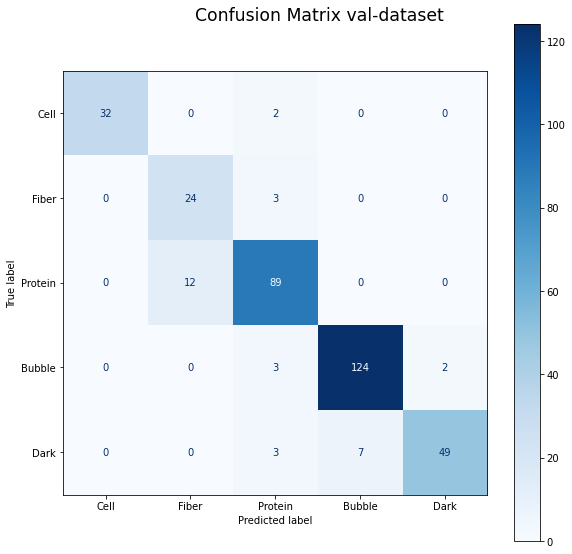

In [7]:
data.plot_confusion_matrix(dataset="val")

In [8]:
data.show_predictions(model.model, dataset='val')
data.show_predictions(model.model, dataset='test')

Accuracy socre on validation set:	 0.9085714285714286
F1 macro socre on validation set:	 0.8923858231320917
Accuracy socre on test set:		 0.9031339031339032
F1 macro socre on test set:		 0.8935241579822737


Predicted: Protein


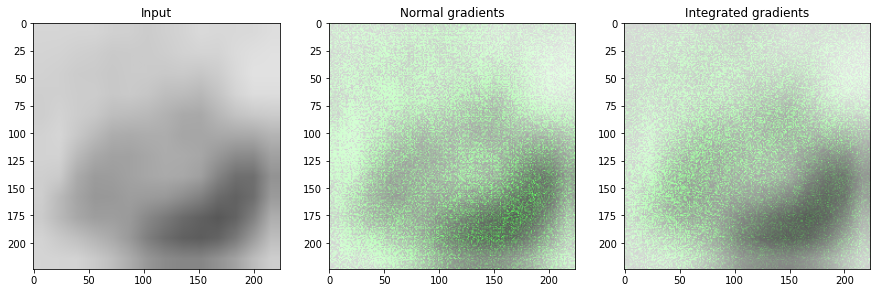

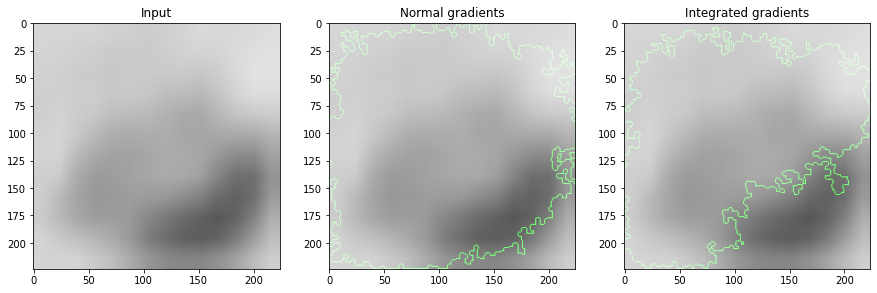

In [9]:
Integrated_Gradients(data, model, dataset='val', image_index=0)

### Small FC network
In the sections above, state-of-the art networks were trained to classify the MFI particles. Here, I test how a simple, fully connected (FC) network compares to these models. My classification tasks seem not to be that difficult. Are the sophisticated neuronal networks really needed, or is a simple FC network also enough for my purposes? This is the question I'm attempting to answer here. In order to prevent overfitting, dropouts and L1/L2 regularization were added.

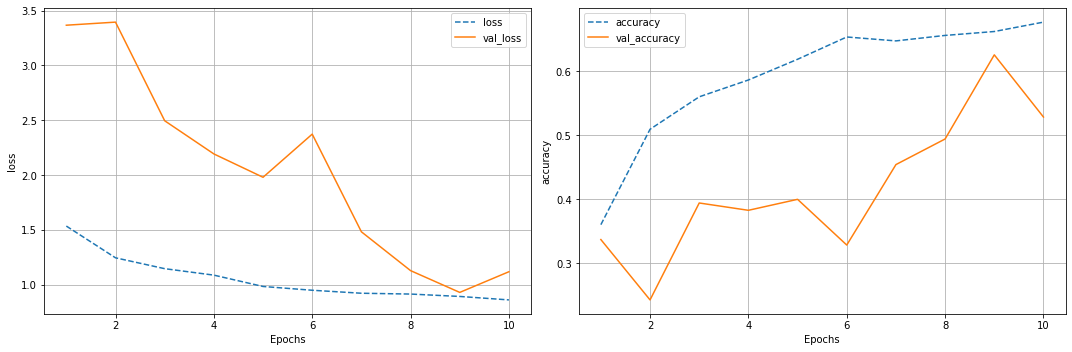


52/52 [==============================] - 1s 10ms/step - loss: 0.8602 - accuracy: 0.6768 - val_loss: 1.1174 - val_accuracy: 0.5286
Saving model ./trained_models/Simple_FC_Network


In [19]:
data = get_preprocessed_data(
    data_dir ='data/dataset2023.13.01', 
    img_height=28, 
    img_width=28, channels=3, 
    resize_option='scale', 
    batch_size=32, 
    data_within_0_1=False,
    test_size_relative=0.15, 
    val_size_relative=0.15,
    scale_to_0_1=False,
    verbose=0,
    augment_train=True
    )

model = Simple_FC_Network(data,
                      lrate = 0.0005,
                      l1 = 0.,
                      l2 = 0.,
                      num_hidden = [64, 16],
                      dropout_prob=0.4,
                      epochs = 20,
                      patience = 10)

model.train_and_evaluate()
save_model(model, './trained_models/Simple_FC_Network')

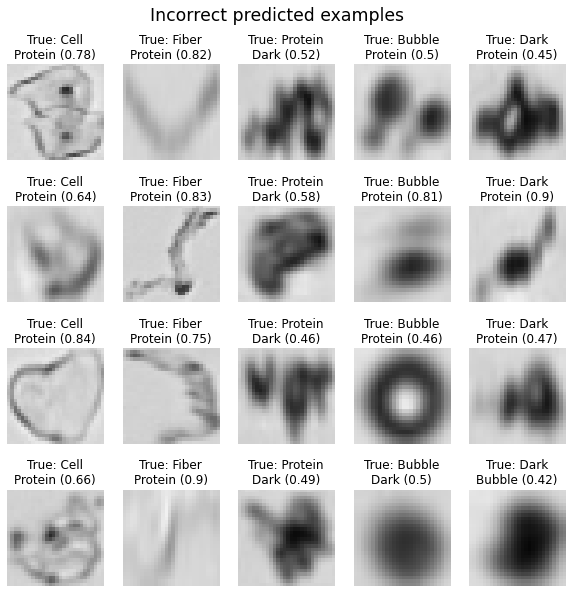

In [20]:
data.plot_prediction(model.model, dataset="val", pred_correct=False, seed=0, examples_per_class=4)

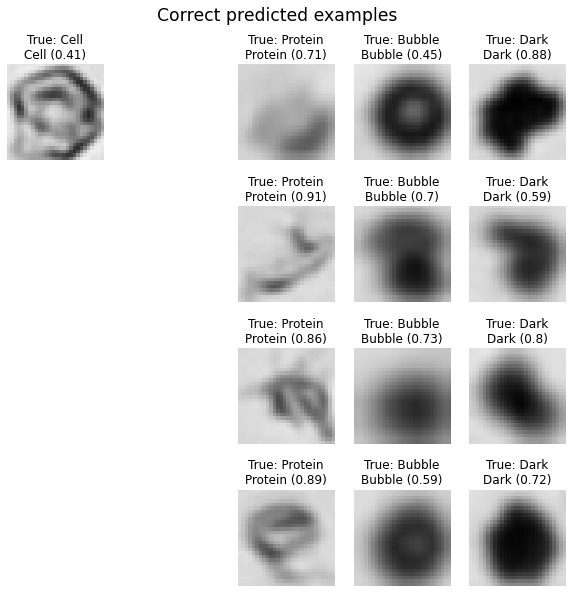

In [21]:
data.plot_prediction(model.model, dataset="val", pred_correct=True, seed=0, examples_per_class=4)

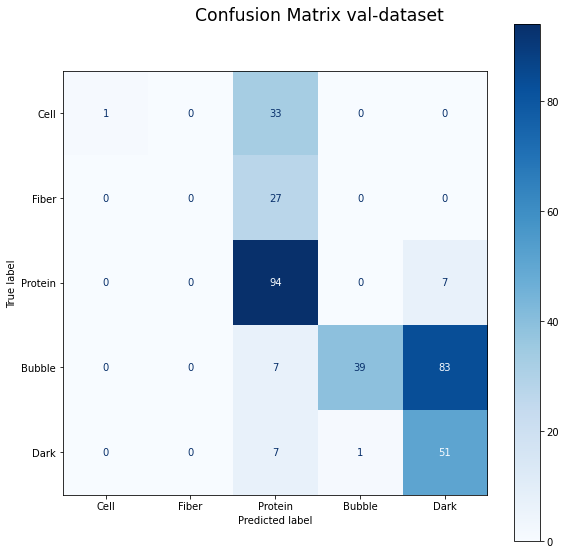

In [22]:
data.plot_confusion_matrix(dataset="val")

In [23]:
data.show_predictions(model.model, dataset='val')
data.show_predictions(model.model, dataset='test')

Accuracy socre on validation set:	 0.5285714285714286
F1 macro socre on validation set:	 0.34551321540912616
Accuracy socre on test set:		 0.5356125356125356
F1 macro socre on test set:		 0.3650453189851971


Predicted: Protein


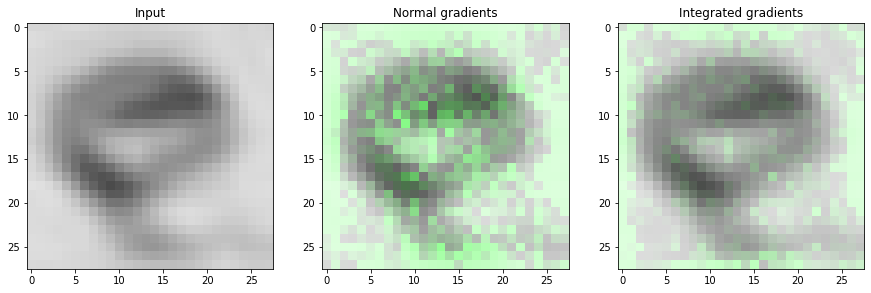

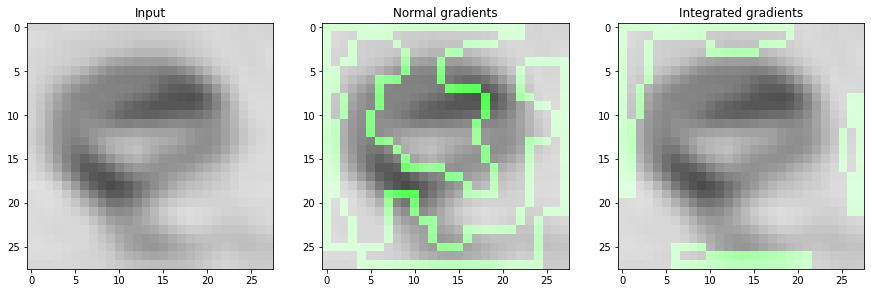

In [24]:
Integrated_Gradients(data, model, dataset='val', image_index=10)

### Model Ensembles
In this section, I try to get even better scores by ensembling the models I already trained above. The goal is to outperform the best model's score with the second and third best models (see the ranking in **Table 2**'s conclusion section).   
A weighted average of the ResNet50 and MobileNet predictions was calculated (weights=0.6/0.4). ResNet50 was weighted slightly more because it performed better on the test set than MobileNet. The result is, in my opinion, surprising. The ensemble of only two models performed massively better than all the single models.

In [14]:
data = get_preprocessed_data(
    data_dir ='data/dataset2023.13.01', 
    img_height=224, 
    img_width=224, 
    channels=3, 
    resize_option='scale', 
    batch_size=16, 
    data_within_0_1=False,
    test_size_relative=0.15, 
    val_size_relative=0.15,
    scale_to_0_1=False,
    verbose=1,
    augment_train=True
    )
paths = ['./trained_models/RESNET50_FINE_TUNE',
         './trained_models/Transfer_Learning_MobileNet']
models = load_models(paths, strategy)
ensemble_output = predict_ensemble(data, models, weights=(0.6, 0.4))
test_labels_as_int = data.get_labels("test")
print("Accuracy socre on test set:\t\t", get_scorer('accuracy')._score_func(test_labels_as_int, ensemble_output))
print("F1 macro socre on test set:\t\t", f1_score(test_labels_as_int, ensemble_output, average='macro'))

Accuracy socre on test set:		 0.9401709401709402
F1 macro socre on test set:		 0.9284308695156606


# Conclusion

A summary of all the model metrics is shown in Table 2. The ranks were given with respect to the F1 score on the test set. The F1 score was considered the most meaningful metric due to the imbalance of the dataset. The comparable results on the test and validation datasets show that a good bias-variance trade-off was found. As expected, the best results were achieved by fine-tuning a pretrained model. The second-best results were achieved by transfer learning. Due to the small size of the dataset, training models from scratch has resulted in worse performance. However, all the models give valuable results. The predicted image examples show that misclassified particles are mostly in borderline cases that are not so clear. In some cases, the label might also be wrong. In contrast to this, the fully connected network, consisting of only two dense layers, shows useless results. On the one hand, this can be seen in the poor metrics.On the other hand, the integrated gradients also show that no useful features were detected. This was the case for all other models. The FC network assigns the majority of particles to only three classes. This is obviously wrong.


Depending on the location of the deployment, I will choose the model to go further with. In cases where performance is not an issue, I will choose the ensemble. In the in case that we will use edge devices, I will proceed with MobileNet. 

**Table 2:** *Summary of results. The ranking is based on the F1 score on the test dataset.* 

|Rank |Model Name              |Type                                   |Trainable parameters|Accuracy Val   |Accuracy Test    | F1 Val   |F1 Test
|-|------                      |------                                 |----                |------         |------           |------    |------
|1|Model Enseble                     |ResNet50+MobileNet               |24M                 |n/a            |0.9401           |n/a       |0.9284
|2|InceptionV3                 |Fine tuning                            |22M                 |0.9600         |0.9288           |0.9288    |0.9180
|3|RESNET50_FINE_TUNE          |Fine tuning                            |24M                 |0.9400         |0.9316           |0.9298    |0.9169
|4|Transfer_Learning_MobileNet |Transfer learning                      |20K                 |0.9114         |0.9116           |0.8994    |0.9031
|5|ResNet34                    |Self-constructed ResNet34 architecture |26M*                |0.8942         |0.9002           |0.8716    |0.8895
|6|RESNET50_FROM_ZERO          |Train from zero                        |24M                 |0.8886         |0.8945           |0.8705    |0.8832
|7|Simple_FC_Network           |Simple FC network trained from scratch |151K                |0.5285         |0.3455           |0.5351    |0.3650

*The origial ResNet34 has less parameters. Did I something wrong?*

The generated models allow further processing of the MFI data and getting more insights into the biological sample material. I created the two notebooks <a href="Apply_Classification_Model_on_Raw_Data.ipynb">Apply_Classification_Model_on_Raw_Data.ipynb</a>  and <a href="data_collection and_analysis/MFI_Analysis_Main.ipynb">data_collection and_analysis/MFI_Analysis_Main.ipynb</a> exactly for this purpose. The automatically generated visualizations aid in making optimal development decisions (see **Figures 2 and 3**).


**Figure 2:** *Histogram of particle size distributions for different particle classes.*
![](https://drive.google.com/uc?id=1OgGg6vhAKef4xchc37cApKIWh2JbHiiZ)
**Figure 3:** *Table of particle size distributions for different particle classes.*
![](https://drive.google.com/uc?id=1hhrFFUga1cThukFQ4ccupx1LcpR3Ofkd)
